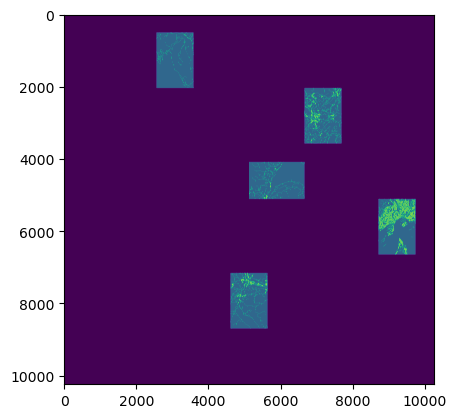

/filserver/frrov/imagery/Sentinel-2/2020/S2B_MSIL2A_20200614T104629_N0500_R051_T32VNM_20230615T035847_aligned_12b.tiff


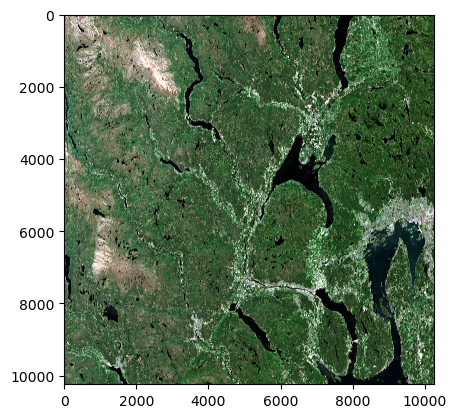

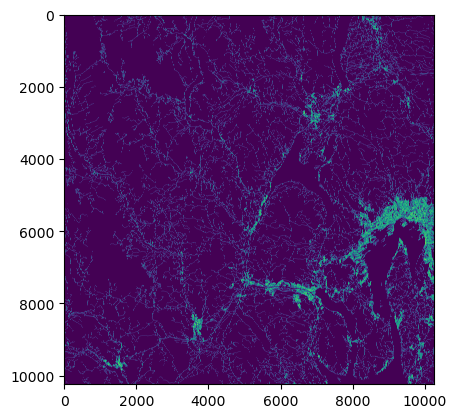

/filserver/frrov/imagery/Sentinel-2/2021/S2A_MSIL2A_20210724T105031_N0500_R051_T32VNM_20230219T234249_aligned_12b.tiff


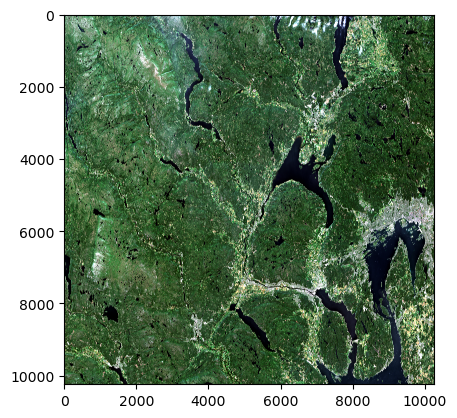

In [2]:
# https://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html

import utils

train_mask_path = '/filserver/user/geodata/rnd_forest_maske_2020.tif'
train_img_path = '/filserver/user/imagery/Sentinel-2/2020/S2B_MSIL2A_20200614T104629_N0500_R051_T32VNM_20230615T035847_aligned_12b.tiff'

test_mask_path = '/filserver/user/geodata/mask_2021.tif'
test_img_path = '/filserver/user/imagery/Sentinel-2/2021/S2A_MSIL2A_20210724T105031_N0500_R051_T32VNM_20230219T234249_aligned_12b.tiff'

utils.show_single_band_img(train_mask_path)

print(train_img_path)
utils.show_msi(train_img_path)

utils.show_single_band_img(test_mask_path)

print(test_img_path)
utils.show_msi(test_img_path)


IMG shape: (10240, 10240, 12)
ROI shape: (10240, 10240)


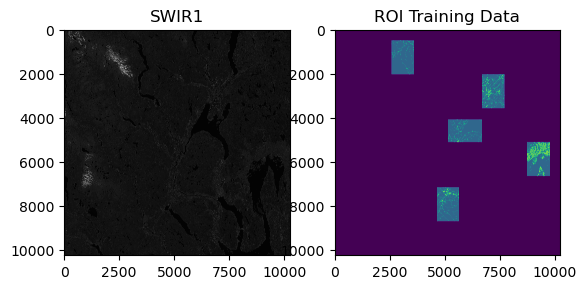

In [3]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

train_img_ds = rio.open(train_img_path)
train_img = np.moveaxis(train_img_ds.read(),0,-1)

train_mask_ds = rio.open(train_mask_path)
train_mask = train_mask_ds.read().squeeze()

print(f'IMG shape: {train_img.shape}')
print(f'ROI shape: {train_mask.shape}')

# Display them
plt.subplot(121)
plt.imshow(train_img[:, :, 4], cmap=plt.cm.Greys_r)
plt.title('SWIR1')

plt.subplot(122)
plt.imshow(train_mask)
plt.title('ROI Training Data')
plt.show()

In [4]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (train_mask > 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(train_mask[train_mask > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

X = train_img[train_mask > 0, :]  # include 8th band, which is Fmask, for now
y = train_mask[train_mask > 0]

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

print('After masking, our X matrix is sized: {sz}'.format(sz=X.shape))
print('After masking, our y array is sized: {sz}'.format(sz=y.shape))

We have 7864320 samples
The training data include 3 classes: [1. 2. 3.]
Our X matrix is sized: (7864320, 12)
Our y array is sized: (7864320,)
After masking, our X matrix is sized: (7864320, 12)
After masking, our y array is sized: (7864320,)


In [15]:
from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(X, y)

In [16]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 92.85659790039062%


In [17]:
bands = [1, 2, 3, 4, 5, 7, 6, 7,8,9,10,11,12]

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.15914466636760097
Band 2 importance: 0.13091157975242299
Band 3 importance: 0.06868775293937131
Band 4 importance: 0.08964430566111536
Band 5 importance: 0.08069463369187314
Band 7 importance: 0.051806056511095155
Band 6 importance: 0.04939072125752252
Band 7 importance: 0.056456263816412104
Band 8 importance: 0.05248089586884562
Band 9 importance: 0.06536645380856398
Band 10 importance: 0.09009860401775273
Band 11 importance: 0.10531806630742406


In [18]:
import pandas as pd

# Setup a dataframe -- just like R
df = pd.DataFrame()
df['truth'] = y
df['predict'] = rf.predict(X)

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict     0.0    1.0     All
truth                         
0.0      224095      0  224095
1.0           0  38049   38049
All      224095  38049  262144


In [19]:
test_img_ds = rio.open(test_img_path)
test_img = np.moveaxis(test_img_ds.read(),0,-1)
meta = test_img_ds.meta.copy()

In [20]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
img_as_array = test_img.reshape(test_img.shape[0] * test_img.shape[1], test_img.shape[2])
print('Reshaped from {o} to {n}'.format(o=test_img.shape,
                                        n=img_as_array.shape))

# Now predict for each pixel
class_prediction = rf.predict(img_as_array)

# Reshape our classification map
class_prediction_img = class_prediction.reshape(test_img[:, :, 0].shape)

Reshaped from (512, 512, 12) to (262144, 12)


(512, 512)


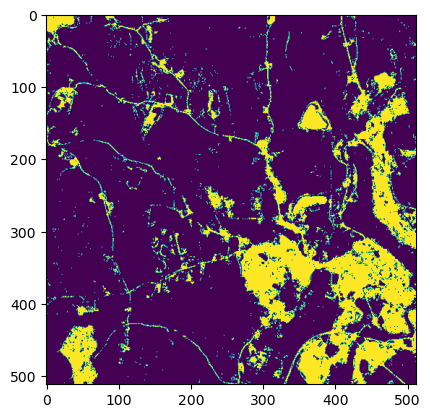

(512, 512)


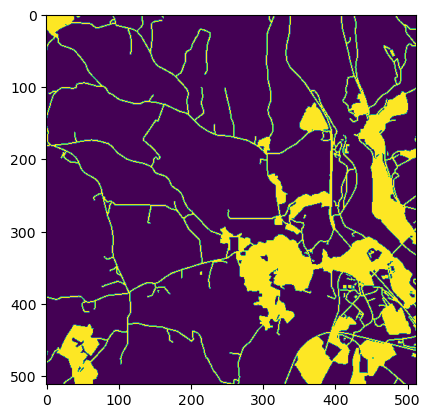

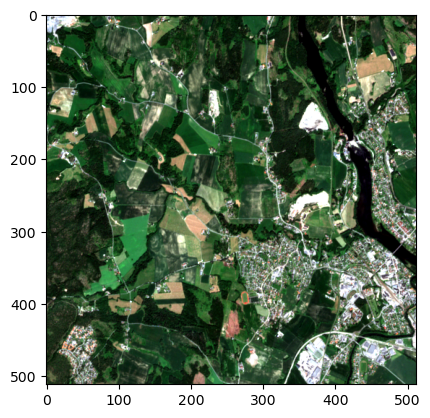

In [21]:
print(class_prediction_img.shape)
plt.imshow(class_prediction_img)
plt.show()

test_mask_ds = rio.open(test_mask_path)
test_mask_3cls = test_mask_ds.read().squeeze()
test_mask = np.where(test_mask_3cls > 1, 1, test_mask_3cls)
print(test_mask.shape)
plt.imshow(test_mask)
plt.show()

utils.show_msi(test_img_path)

Predicted,0.0,1.0
Actual,,
0.0,0.931563,0.068437
1.0,0.267520,0.732480


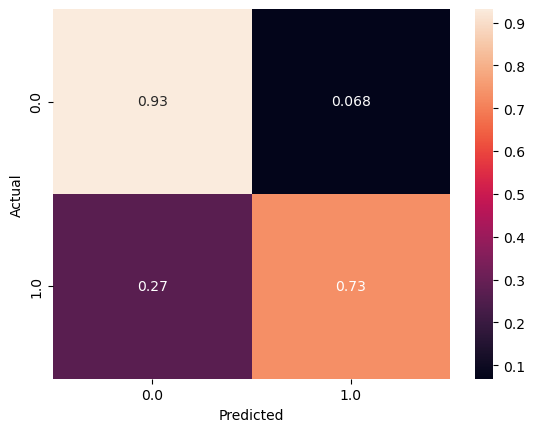

In [22]:
import seaborn as sns

test_mask_arr = test_mask.flatten()

y_actu = pd.Series(test_mask_arr, name='Actual')
y_pred = pd.Series(class_prediction, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'],normalize='index')
display(df_confusion)

sns.heatmap(df_confusion, annot=True)
plt.show()

In [72]:
from numpy import newaxis
outpath_img = '/filserver/frrov/imagery/test_rnd_forst.tiff'
meta['count'] = 1
meta['dtype'] = 'uint8'
print(meta)
print(class_prediction_img[:,:,newaxis].shape)
with rio.open(outpath_img, 'w', **meta) as out_img_ds:
    out_img_ds.write(class_prediction_img[newaxis,:,:])

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 512, 'height': 512, 'count': 1, 'crs': CRS.from_epsg(25832), 'transform': Affine(10.0, 0.0, 532480.0,
       0.0, -10.0, 6614840.0)}
(512, 512, 1)
